## MNIST

In this notebook, we want to reproduce the MNIST CapsNet from Hinton 2017.

## Setup

In [2]:
# Imports
%load_ext autoreload
%autoreload 2

In [3]:
from os.path import join

import numpy as np
import tensorflow as tf
%matplotlib inline

from caps import layers, losses
from data import mnist, utils
from utils import evaluate, reset, new_experiment, Logger

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
reset()

## MNIST Dataset

In [5]:
train_data, val_data, test_data = mnist.load_data(force=True)

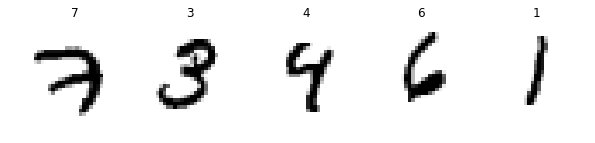

In [6]:
utils.peek(train_data)

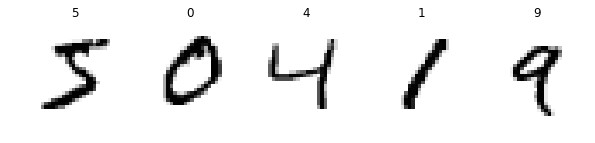

In [7]:
utils.peek(val_data)

## CapsNet model

In [10]:
reset()

## Inputs
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")
y_one_hot = tf.one_hot(y, depth=10, name="y_one_hot")

## Model
conv1 = tf.layers.conv2d(
    X, 
    filters=256,
    kernel_size=9,
    strides=1,
    padding="valid",
    name="conv1"
)

primaryCaps = layers.primaryCaps(
    conv1, 
    caps=32, 
    dims=8,
    kernel_size=9,
    strides=2,
    name="primaryCaps"
)

digitCaps = layers.denseCaps(
    primaryCaps, 
    caps=10, 
    dims=16
)


probabilities = layers.norm(digitCaps, axis=-1, name="probabilities")
margin_loss = losses.margin_loss(y_one_hot, probabilities, name="margin_loss")


predictions = tf.argmax(probabilities, axis=-1, name="predictions")
with tf.variable_scope("accuracy"):
    correct = tf.equal(y, predictions, name="correct")
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    

with tf.variable_scope("reconstructions"):
    mask_with_labels = tf.placeholder_with_default(False, shape=(), name="mask_with_labels")

    reconstruction_targets = tf.cond(mask_with_labels,
                                     lambda: y,
                                     lambda: predictions,
                                     name="reconstruction_targets")

    reconstructions = layers.denseDecoder(digitCaps, reconstruction_targets, [512, 1024, 28*28], name="reconstructions")
    
reconstruction_loss = losses.reconstruction_loss(X, reconstructions, name='reconstruction_loss')

alpha = tf.constant(0.0005, name='alpha')
loss = margin_loss + alpha * reconstruction_loss

In [ ]:
optimizer = tf.train.AdamOptimizer()
train_step  = optimizer.minimize(loss, name="training_op")

init = tf.global_variables_initializer()

batch_size = 448
num_epochs = 20
                                    
logdir = new_experiment(root_logdir=join('./experiments', 'mnist'))
logger = Logger(logdir)

checkpoint_path = join(logdir, 'parameters')
saver = tf.train.Saver()
    

def train_hook(session, iteration, iterations, loss, accuracy):
    return '\rTrain | Iteration {}/{} ({:.1f}%) | Batch Accuracy: {:.4f}% Loss: {:.6f}'.format(
        iteration,
        iterations,
        iteration * 100 / iterations,
        accuracy * 100,
        loss
    )

def validation_hook(session, iteration, iterations, loss, accuracy):
    return '\rValidation | Iteration {}/{} ({:.1f}%) | Batch Accuracy: {:.4f}% Loss: {:.6f}'.format(
        iteration,
        iterations,
        iteration * 100 / iterations,
        accuracy * 100,
        loss
    )

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    init.run()
    
    best_val_loss = np.infty
    
    for epoch in range(num_epochs):
        print('[Epoch {}/{}]'.format(epoch + 1, num_epochs))
        
        # TRAINING PHASE
        train_loss, train_accuracy = evaluate(
            session=sess,         
            inputs=[X, y], 
            dataset=train_data,
            train_step=train_step,
            batch_size=batch_size,
            feed_dict={mask_with_labels: True},
            metrics=[loss, accuracy],
            report_every=10,
            report_hook=train_hook
        )
        
        print(
            '\rTrain | Average Accuracy: {:.4f}% Loss: {:.6f}'.format(
                train_accuracy * 100,
                train_loss
            ), 
            end=" " * 50 + "\n"
        )
        
        logger.add('train_loss', train_loss, epoch)
        logger.add('train_accuracy', train_accuracy, epoch)
        
        # VALIDATION PHASE
        val_loss, val_accuracy = evaluate(
            session=sess,         
            inputs=[X, y], 
            dataset=val_data,
            batch_size=batch_size,
            metrics=[loss, accuracy],
            report_every=10,
            report_hook=validation_hook
        )
        
        print(
            '\rValidation | Average Accuracy: {:.4f}% Loss: {:.6f}'.format(
                val_accuracy * 100,
                val_loss
            ), 
            end=" " * 50 + "\n"
        )
        
        logger.add('val_loss', val_loss, epoch)
        logger.add('val_accuracy', val_accuracy, epoch)
        
        if val_loss < best_val_loss:
            saver.save(sess, checkpoint_path)
            best_val_loss = val_loss

    logger.write()

[Epoch 1/20]
Train | Average Accuracy: 89.6493% Loss: 0.129854                                                  
Validation | Average Accuracy: 96.2632% Loss: 0.050236                                                  
[Epoch 2/20]
Train | Iteration 40/122 (32.8%) | Batch Accuracy: 95.5357% Loss: 0.052459

In [ ]:
# Testing

# Uncomment the line below to re-test other experiments
# checkpoint_path = '...'

def test_hook(session, iteration, iterations, accuracy):
    return '\rEvaluation | Iteration {}/{} ({:.1f}%)'.format(
        iteration,
        iterations,
        iteration * 100 / iterations
    )

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    test_accuracy = evaluate(
            session=sess,         
            inputs=[X, y], 
            dataset=test_data,
            batch_size=batch_size,
            metrics=[accuracy],
            report_every=10,
            report_hook=test_hook
        )
    
    print("\rEvaluation | Accuracy: {:.4f}%".format(test_accuracy * 100), end=" " * 50 + "\n")

In [63]:
# Predictions

num_samples = 2
sample_images, sample_labels = next(train_data.batch(num_samples))

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    digitCaps_output, reconstructions_output, predictions_output = sess.run(
        [digitCaps, reconstructions, predictions],
        feed_dict={
            X: sample_images,
            y: np.array([], dtype=np.int64) # will not be used
        },
    )

INFO:tensorflow:Restoring parameters from ./experiments/mnist/2018-06-13_15-22-58/parameters


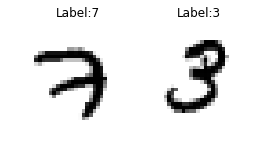

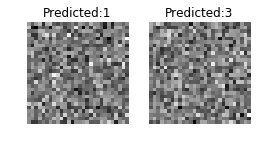

In [64]:
sample_images = sample_images.reshape([-1, 28, 28])
reconstructions_output = reconstructions_output.reshape([-1, 28, 28])

plt.figure(figsize=(num_samples * 2, 3))
for index in range(num_samples):
    plt.subplot(1, num_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(sample_labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(num_samples * 2, 3))
for index in range(num_samples):
    plt.subplot(1, num_samples, index + 1)
    plt.imshow(reconstructions_output[index], cmap="binary")
    plt.title("Predicted:" + str(predictions_output[index]))
    plt.axis("off")